# WRF perturbations

In [1]:
%cd ~/git/wrf_lrf_les/

/home/561/tr2908/git/wrf_lrf_les


In [2]:
import sys

sys.path.append("analysis/")

import datetime

import matplotlib.pyplot as plt
import modules.wrf_perturbation as wp
import numpy as np

print("Report last updated at " + str(datetime.datetime.now()) + " UTC.")  # noqa: DTZ005

Report last updated at 2025-04-08 14:56:47.519394 UTC.


## Settings

In [3]:
# Directories for results to read.
dirs = {"1 km": "1km", "4 km": "4km", "100 m": "LES"}

# The point at which the RCE run ends and control + perturbation runs begin.
runs_start = {
    "4 km": "2000-03-01",
    "1 km": "2000-03-01",
    "100 m": "2000-04-25",
}

# Start and end times for designated RCE periods.
RCE_times = {
    "4 km": ["2000-04-01", "2000-06-01"],
    "1 km": ["2000-04-01", "2000-06-01"],
    "100 m": ["2000-05-10", "2000-05-18 16:00"],
}

# Perturbation details.
perts = {
    "res": list(dirs.keys()),  # Dataset names.
    "dir": [dirs[x] for x in dirs],  # Dataset directories.
    "levels": ["850", "730", "600", "500", "412"],  # Perturbed levels in hPa.
    "T": ["0.5", "-0.5"],  # Temperature perturbations in K day-1.
    "q": ["0.0002", "-0.0002"], # Specific humidity perturbations in kg kg-1 day-1.
}

# Input directories with dataset names as keys.
basedir = "/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/"
inputs = wp.input_map(perts=perts, basedir=basedir)

# Figure settings.
plt.rcParams["figure.figsize"] = wp.FIGURE_SIZE  # Figure size for non-facetted plots.
plt.rcParams["font.size"] = 14  # Font size for plots.
plt.rcParams["axes.formatter.useoffset"] = False  # Don't use offsets in plots.

plot_levels = [850, 500, 410, 100]  # Pressure levels to plot individually [hPa].

## Read data

The script `~/code/sh/extract_WRF_variables_parallel.sh` runs, in parallel, a python script that extracts variables of interest from WRF `wrfout` files, optionally interpolates the 3D variables to vertical pressure levels, and takes spatial means across horizontal dimensions. These profiles of mean values per time are written to `wrfvar` files, which are then opened here. Note results are cached in `data/WRF`.

In [4]:
wrf_pw_ts, wrf_profs, wrf_pw_sv_ts, wrf_responses, wrf_responses_std = wp.load_cache_data(
    inputs=inputs, dirs=dirs, runs_start=runs_start, RCE_times=RCE_times,
)

Read MONC data:

In [5]:
monc_cwv = wp.MONC_CWV_data()
monc_responses = wp.MONC_response_data()

Collect responses into one DataFrame:

In [6]:
all_responses = wp.concat_diffs(responses=[wrf_responses, monc_responses])

Read reference data from Kuang et al.

In [7]:
ref_responses = wp.kuang_data(ref_dir="/g/data/up6/tr2908/LRF_SCM_results/")

## Radiative-convective equilibrium (RCE)

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation in WRF. The green highlighted region is the time span over which average profiles are calculated for all runs. MONC is also included here.

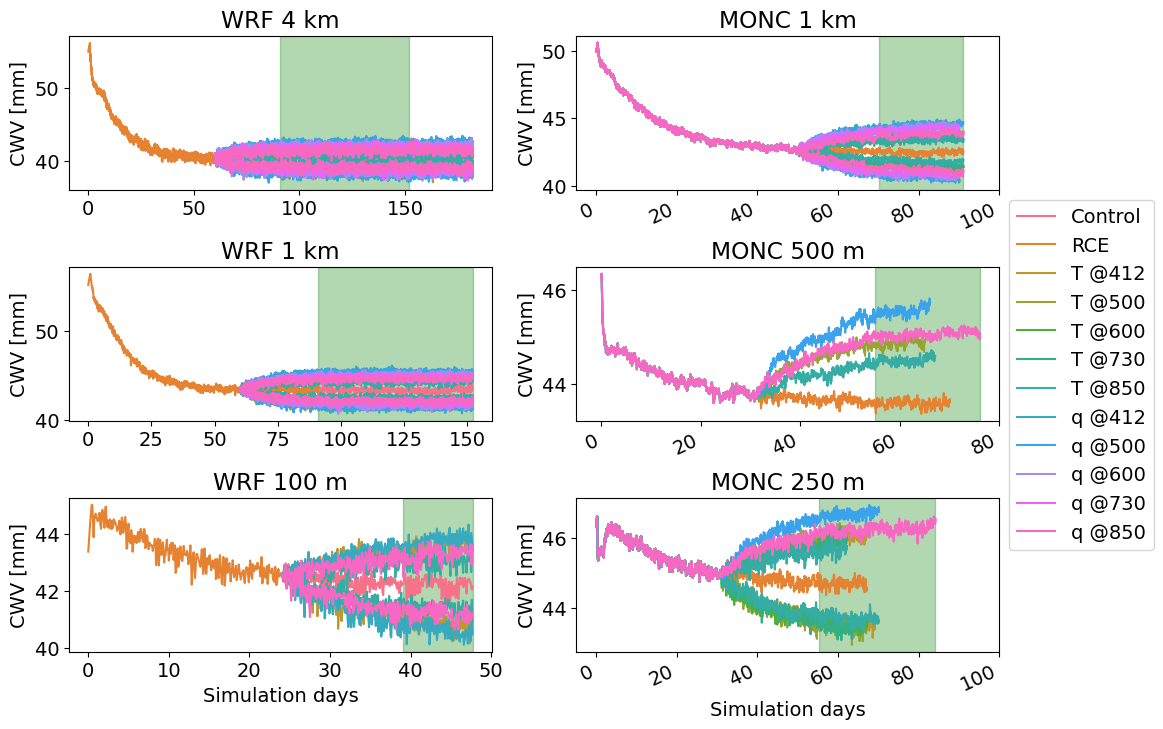

In [8]:
wp.plot_ts_wrf_monc(
    wrf_pw_ts=wrf_pw_ts,
    monc_cwv=monc_cwv,
    WRF_RCE_times=RCE_times,
    file='paper/figures/runs_timeseries.pdf',
)

## Mean profiles for RCE period

In [49]:
from importlib import reload
reload(wp)

<module 'modules.wrf_perturbation' from '/home/561/tr2908/git/wrf_lrf_les/analysis/modules/wrf_perturbation.py'>

In [50]:
ctrl_profs = wp.mean_control_profiles(wrf_profs=wrf_profs)

In [51]:
ctrl_profs[ctrl_profs.Model == 'MONC']

level           T          tk          q        ua        va  \
0   1003.579007  303.317001  303.626678  33.603515 -0.000000  0.000000   
1    996.414024  298.983000  298.676370  15.277180  4.313953 -0.001689   
2    989.248403  298.889887  297.968457  15.066535  4.488253 -0.002276   
3    982.007958  298.930632  297.384433  14.956032  4.591326 -0.001944   
4    974.613134  298.952008  296.764286  14.892975  4.642990 -0.001682   
..          ...         ...         ...        ...       ...       ...   
78    75.072059  388.821158  182.707792   0.000816  4.998713  0.000221   
79    68.894223  400.010731  183.273763   0.001012  4.998833  0.000734   
80    63.116632  411.274025  183.628707   0.001173  4.998275  0.000414   
81    57.773487  422.490466  183.764444   0.001275  4.997886  0.000588   
82    52.866376  433.786935  183.770753   0.001328  4.863023 -0.141436   

            rh        qcloud      qice          qsnow         qrain  \
0   118.937978  0.000000e+00  0.000000   0.000000e+00  0.000000e+00   
1    72.427410  1.434996e-96  0.000000   0.000000e+00  6.142267e-03   
2    74.050090  4.335880e-83  0.000000   0.000000e+00  5.994374e-03   
3    75.628117  1.292772e-76  0.000000  9.881313e-324  5.922856e-03   
4    77.648969  3.509470e-54  0.000000  4.046693e-281  5.921730e-03   
..         ...           ...       ...            ...           ...   
78   63.508461  2.236899e-14  0.000070   2.409869e-06  8.543079e-25   
79   64.776457  3.877454e-13  0.000055   1.249844e-06  1.503732e-23   
80   64.164694  9.103074e-14  0.000036   8.410505e-07  5.718523e-24   
81   62.093740  1.987113e-12  0.000019   8.603319e-07  1.184492e-22   
82   58.847188  1.286235e-34  0.000016   1.314906e-05  4.340256e-44   

          qgraup Resolution Model  
0   0.000000e+00       1 km  MONC  
1   1.292413e-07       1 km  MONC  
2   1.520468e-07       1 km  MONC  
3   1.793233e-07       1 km  MONC  
4   2.119018e-07       1 km  MONC  
..           ...        ...   ...  
78  1.312901e-12      250 m  MONC  
79  5.087595e-33      250 m  MONC  
80  7.570927e-56      250 m  MONC  
81  3.345522e-72      250 m  MONC  
82  8.536752e-78      250 m  MONC  

[249 rows x 14 columns]

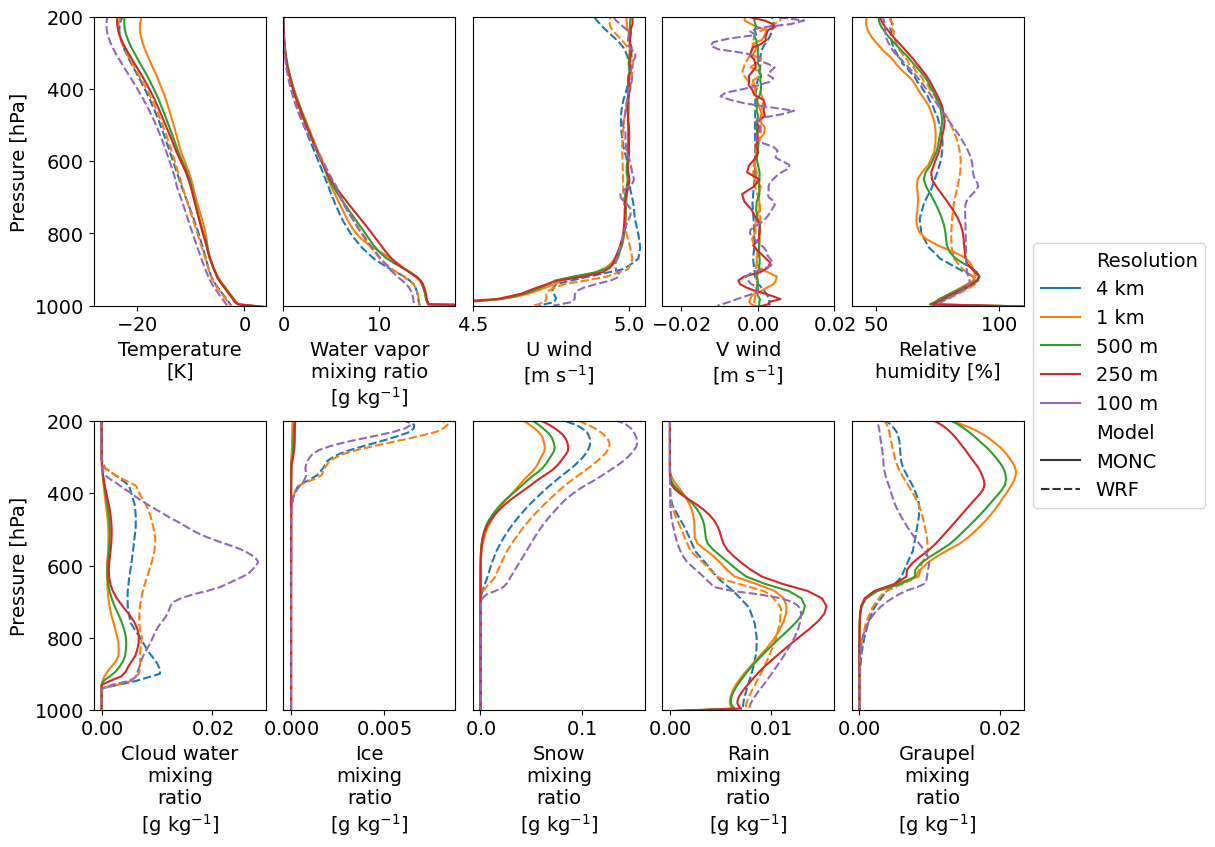

In [56]:
ctrl_profs = wp.mean_control_profiles(wrf_profs=wrf_profs)
wp.plot_mean_profiles(profs=ctrl_profs, file='paper/figures/rce_profiles.pdf', figsize=(12, 9), retick={'va': [-0.02, 0, 0.02]},
                      xlims={'q': (0, 18), 'ua': (4.5, 5.05), 'va': (-0.025, 0.02), 'rh': (40, 110), 'tk': (-28, 4)})

## Convective organisation

Examine the spatial variance of precipitable water scaled by its spatial mean (not shown in paper) to see whether there is any evidence of convective organisation.

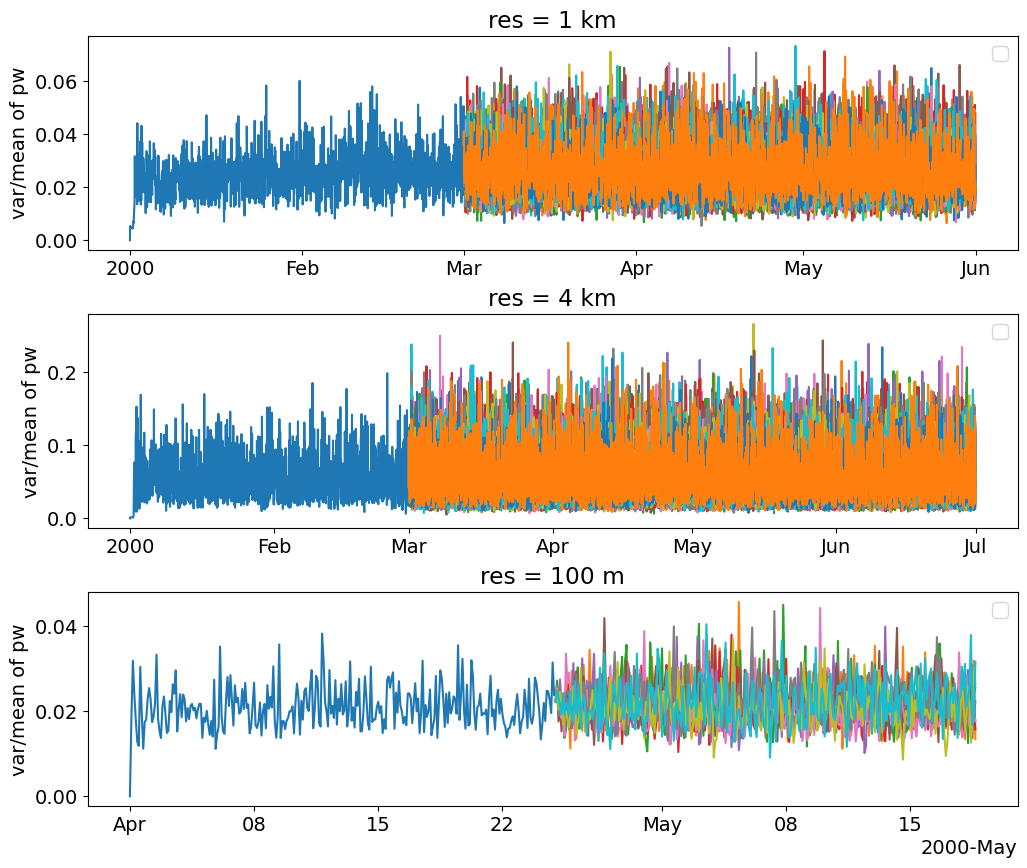

In [ ]:
_, axs = plt.subplots(figsize=(12,10), nrows=len(wrf_pw_sv_ts), gridspec_kw={'hspace': 0.3})
for i, res in enumerate(wrf_pw_sv_ts):
    wrf_pw_sv_ts[res].pw_scaled_var.plot(x='time', hue='Dataset', ax=axs[i])
    axs[i].legend([])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('var/mean of pw')

## Differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

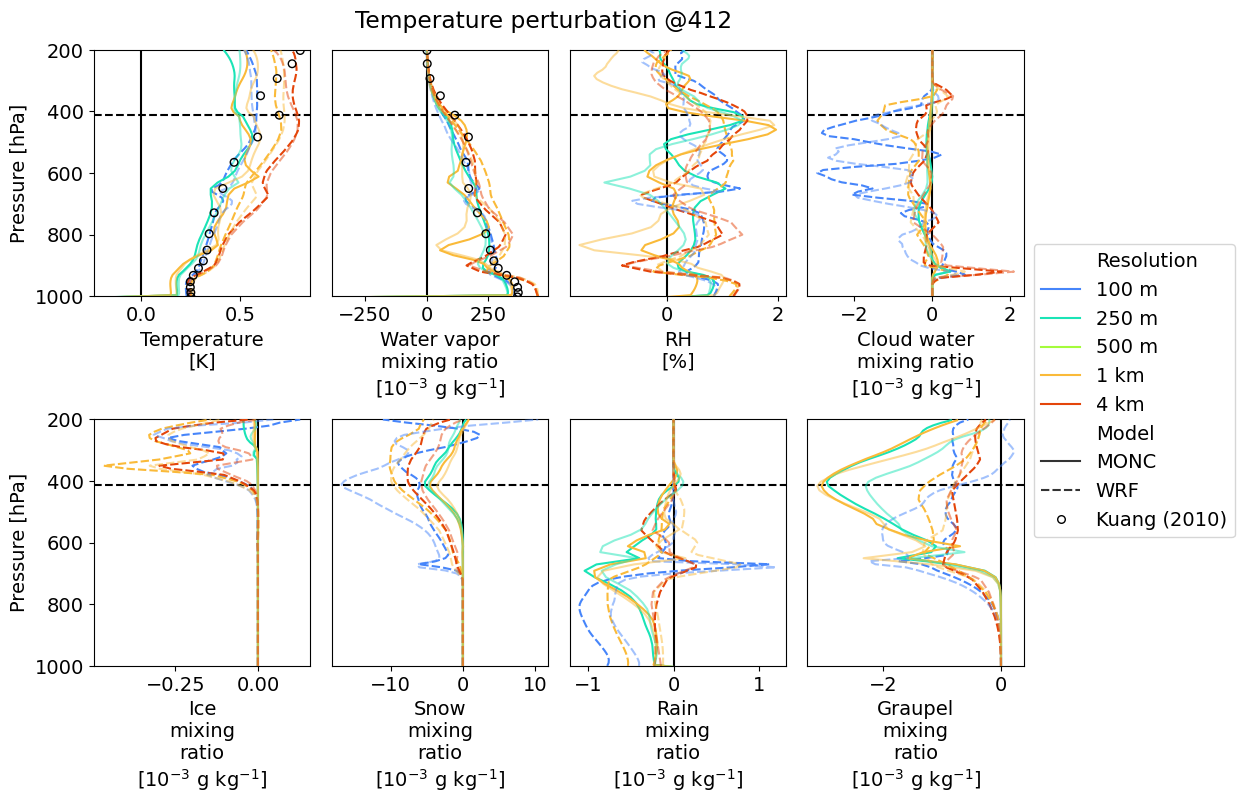

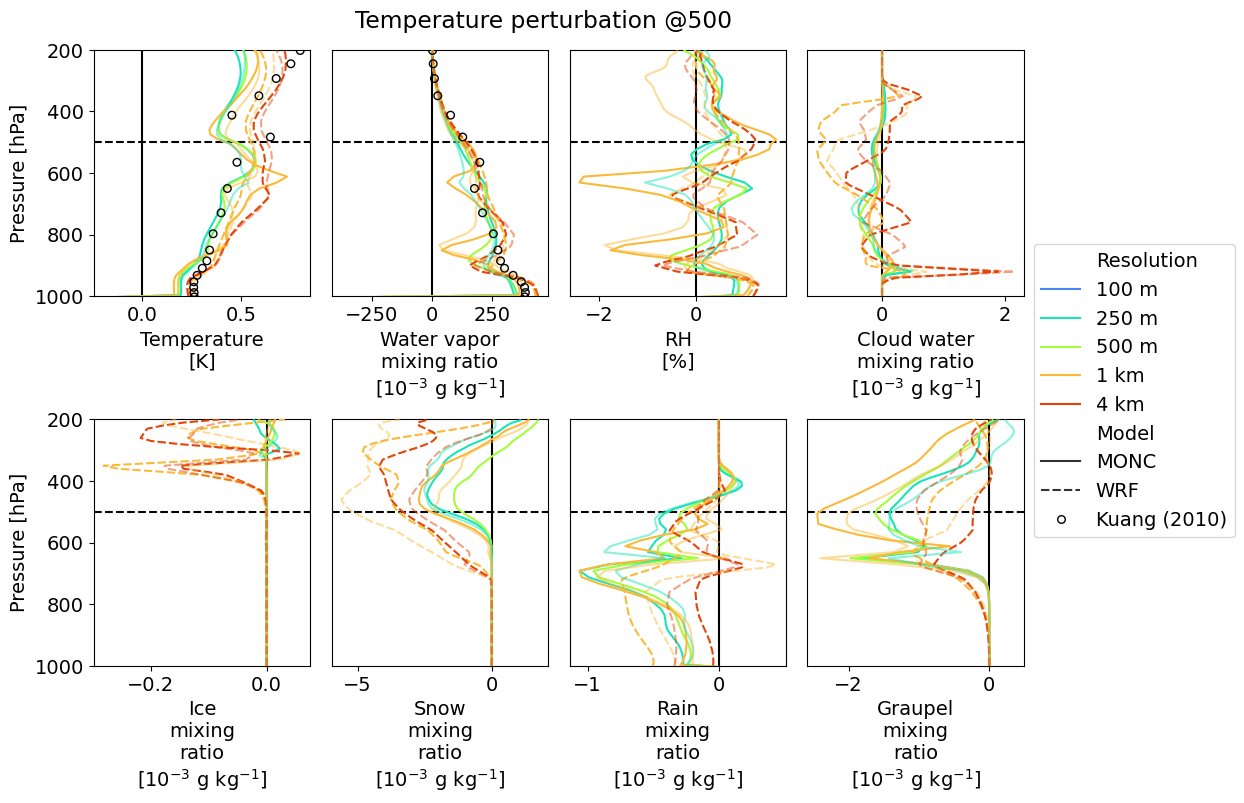

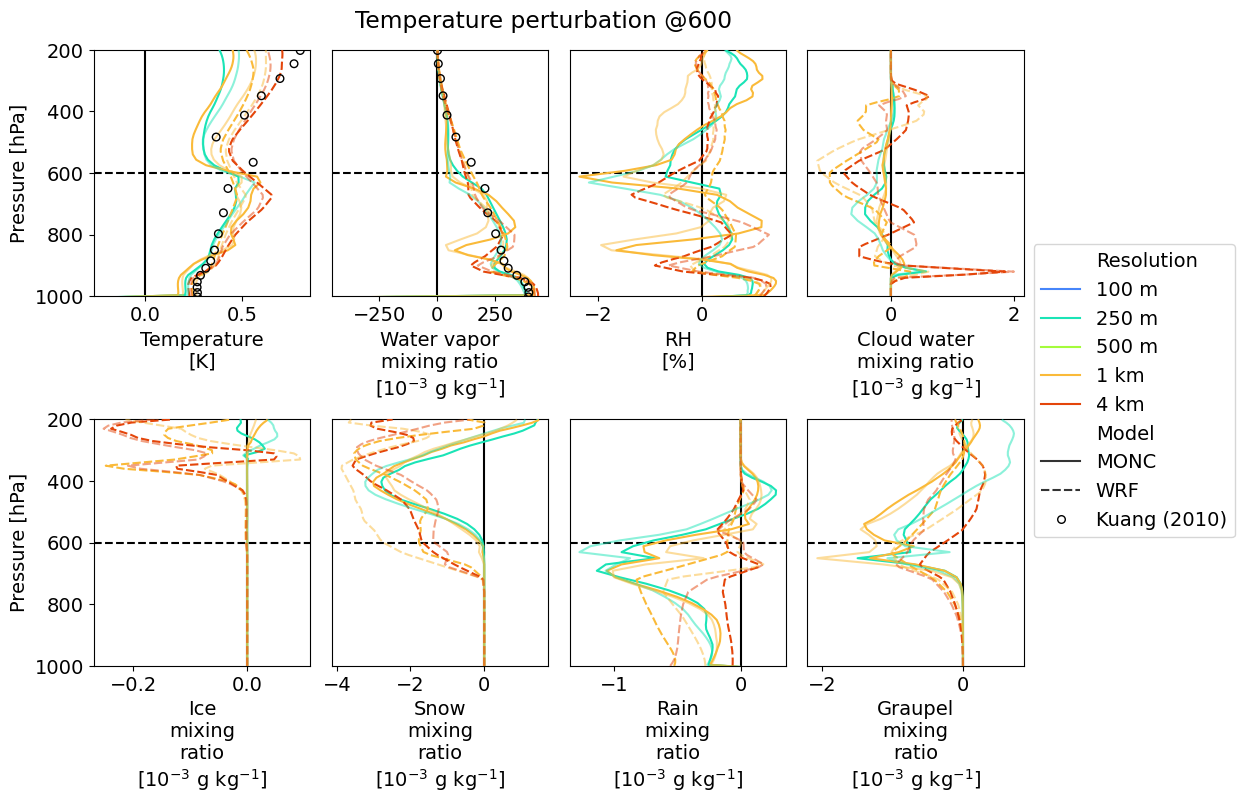

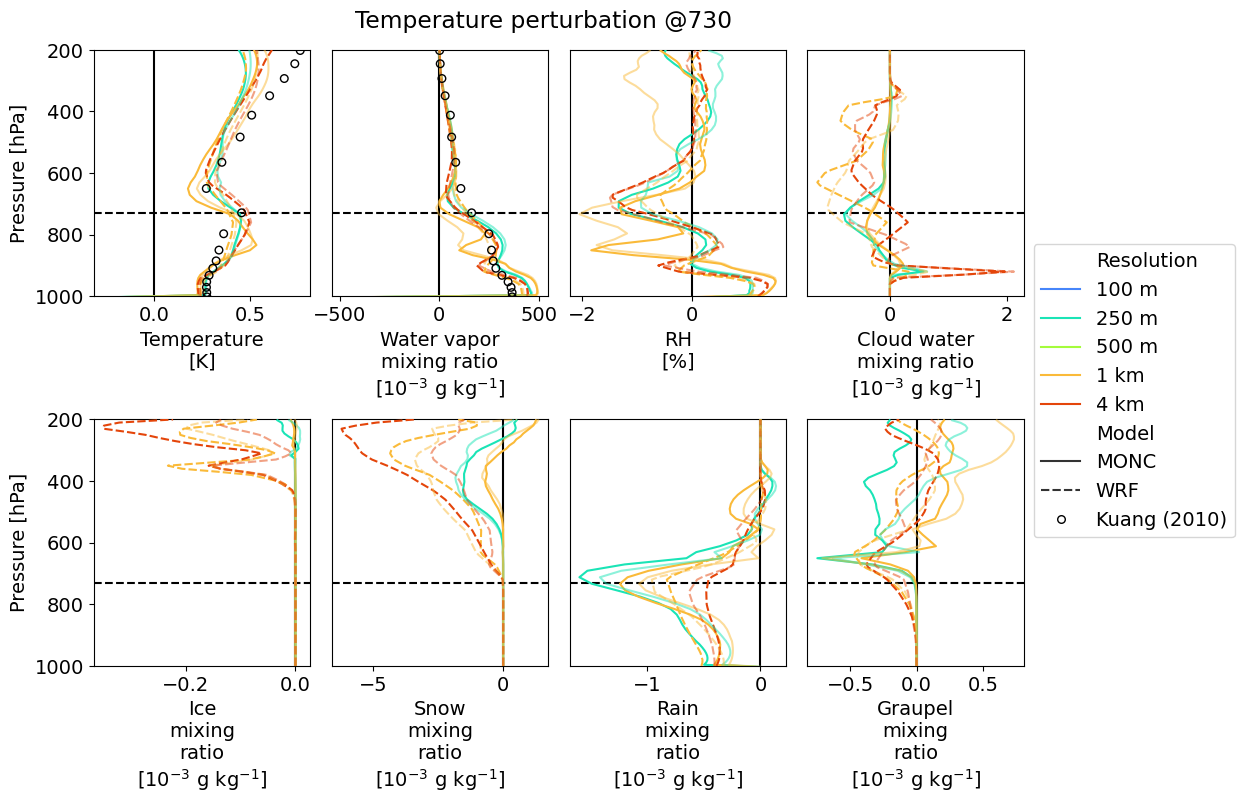

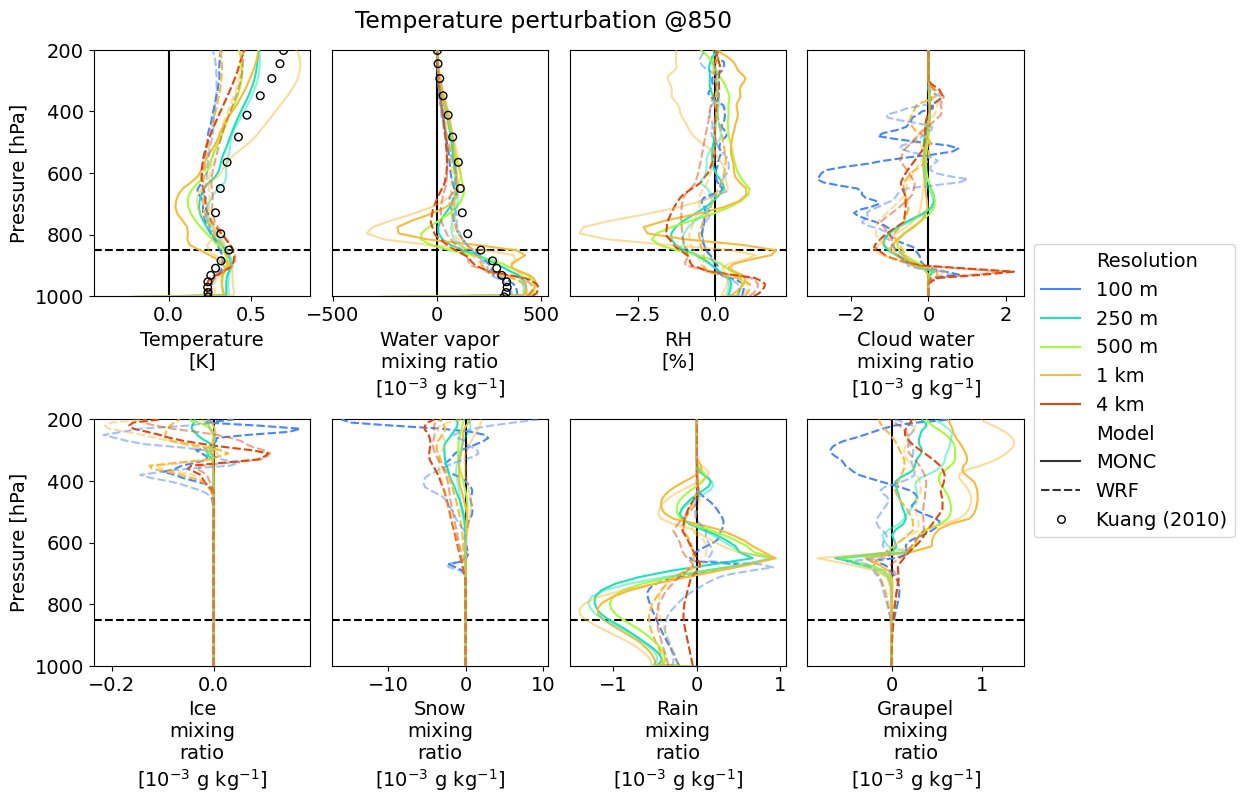

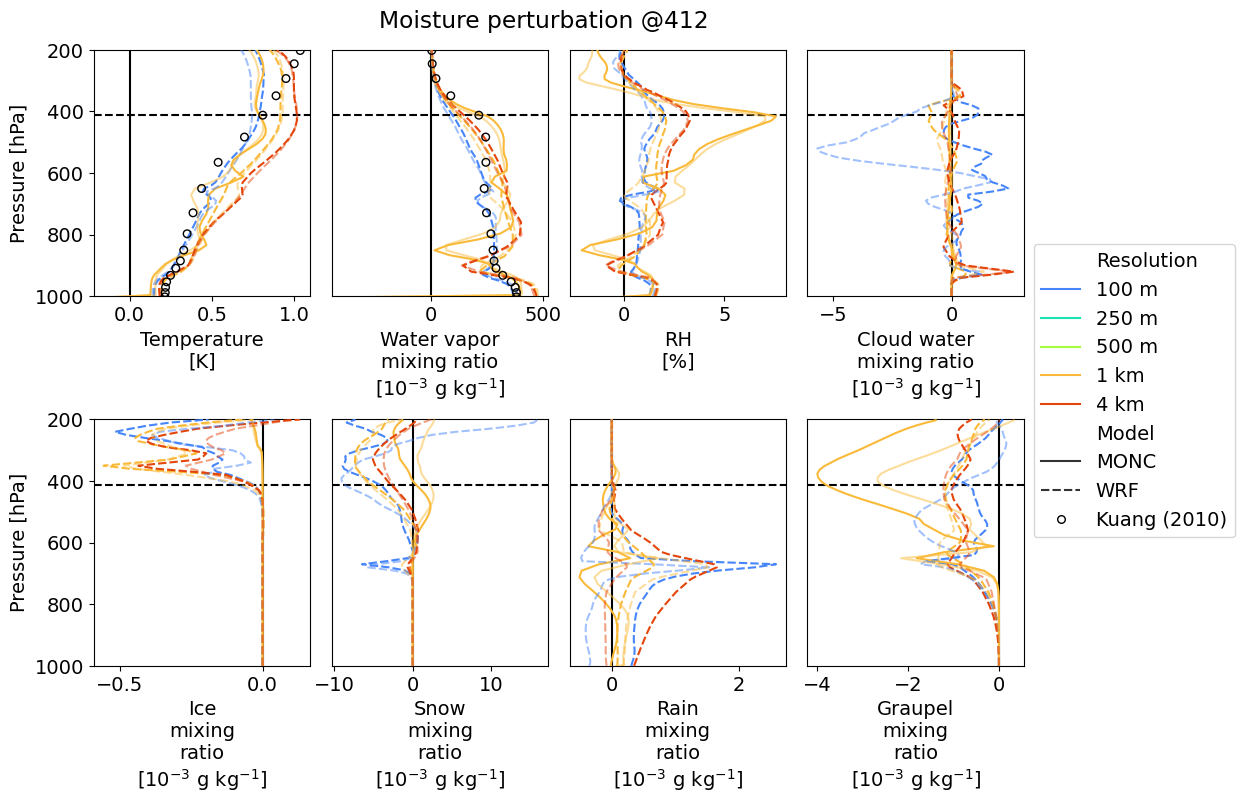

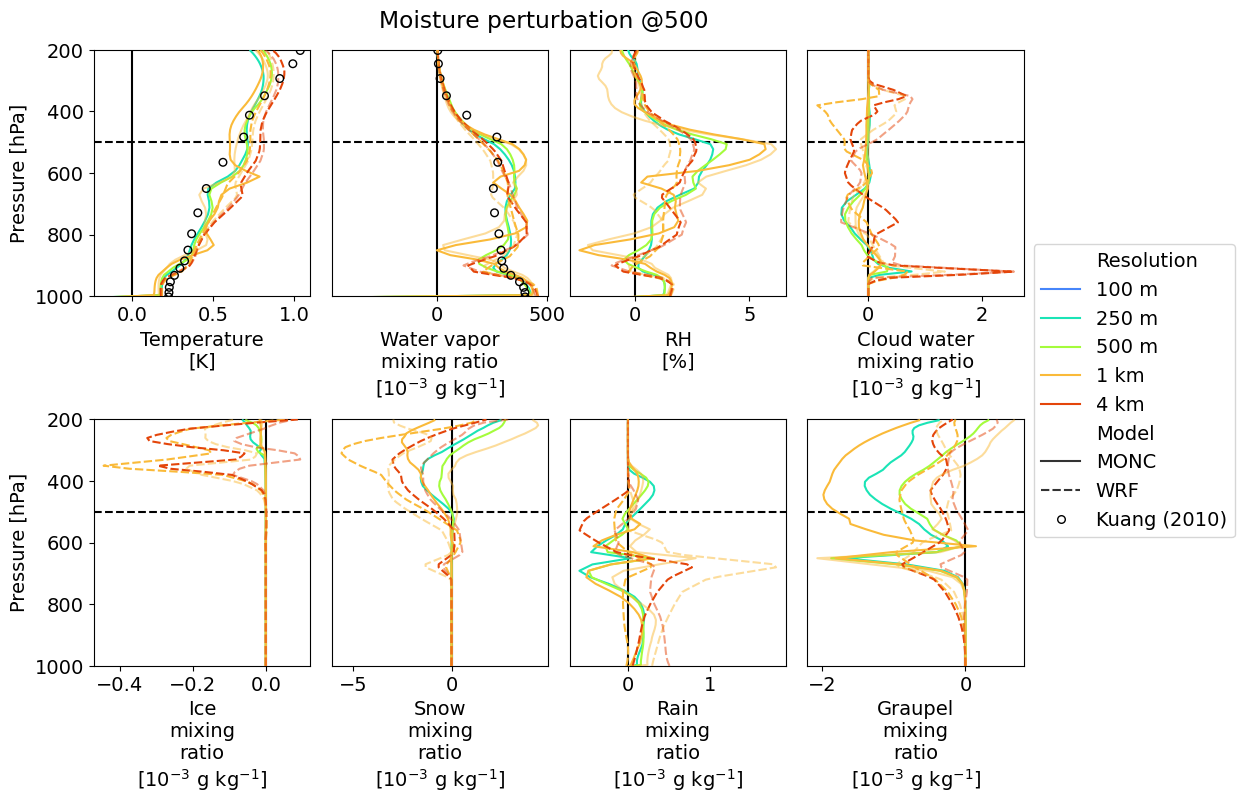

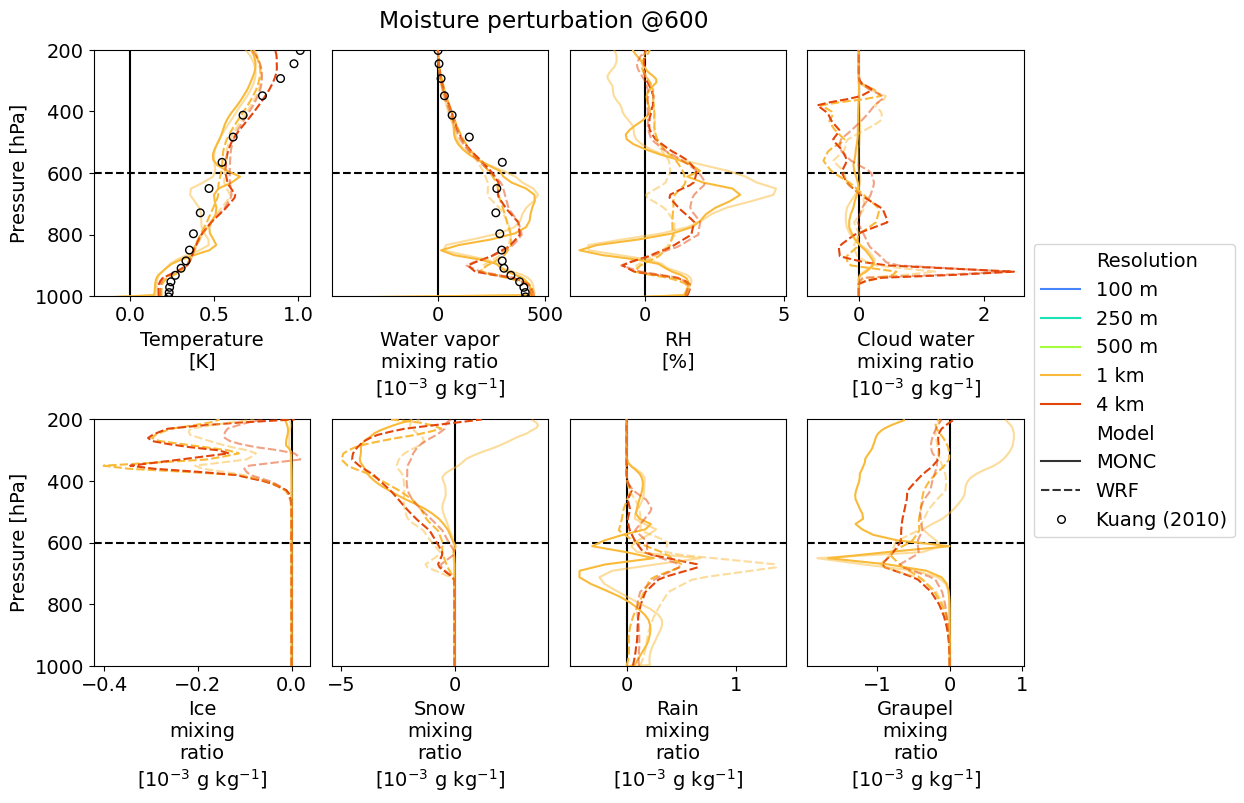

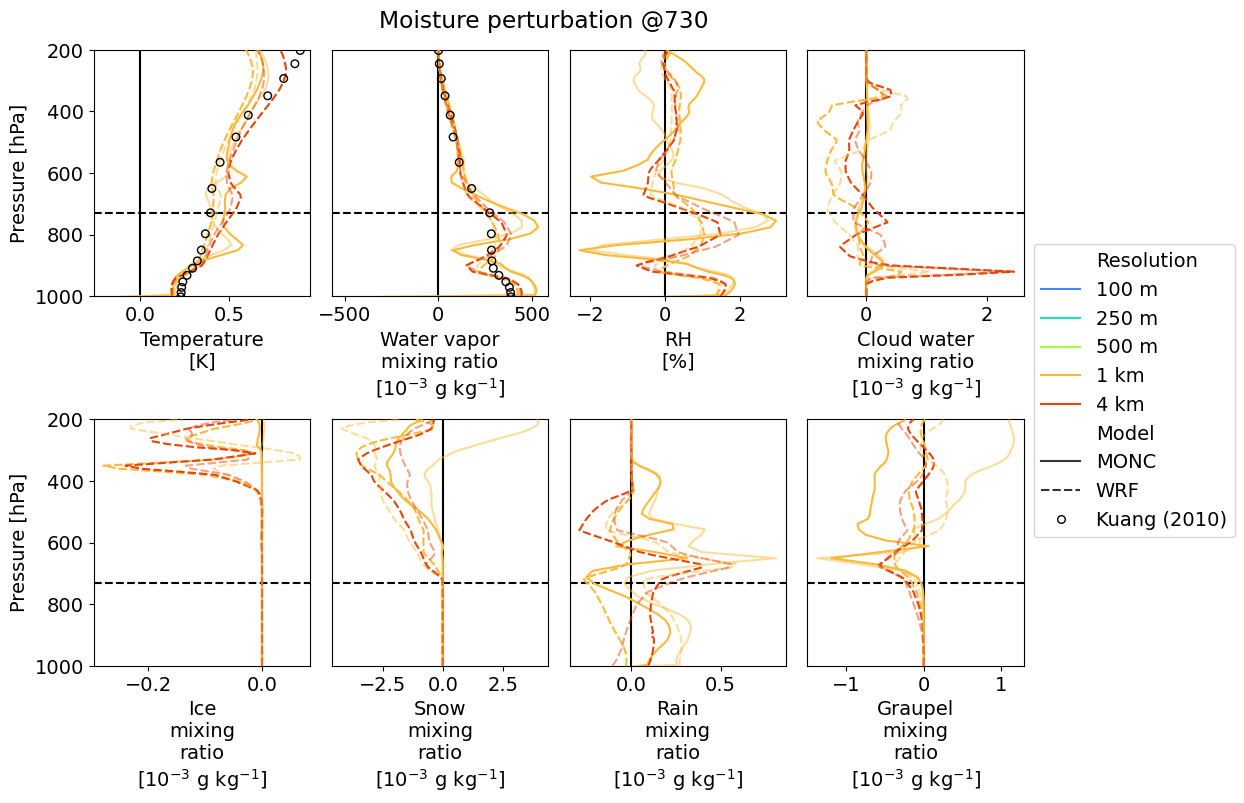

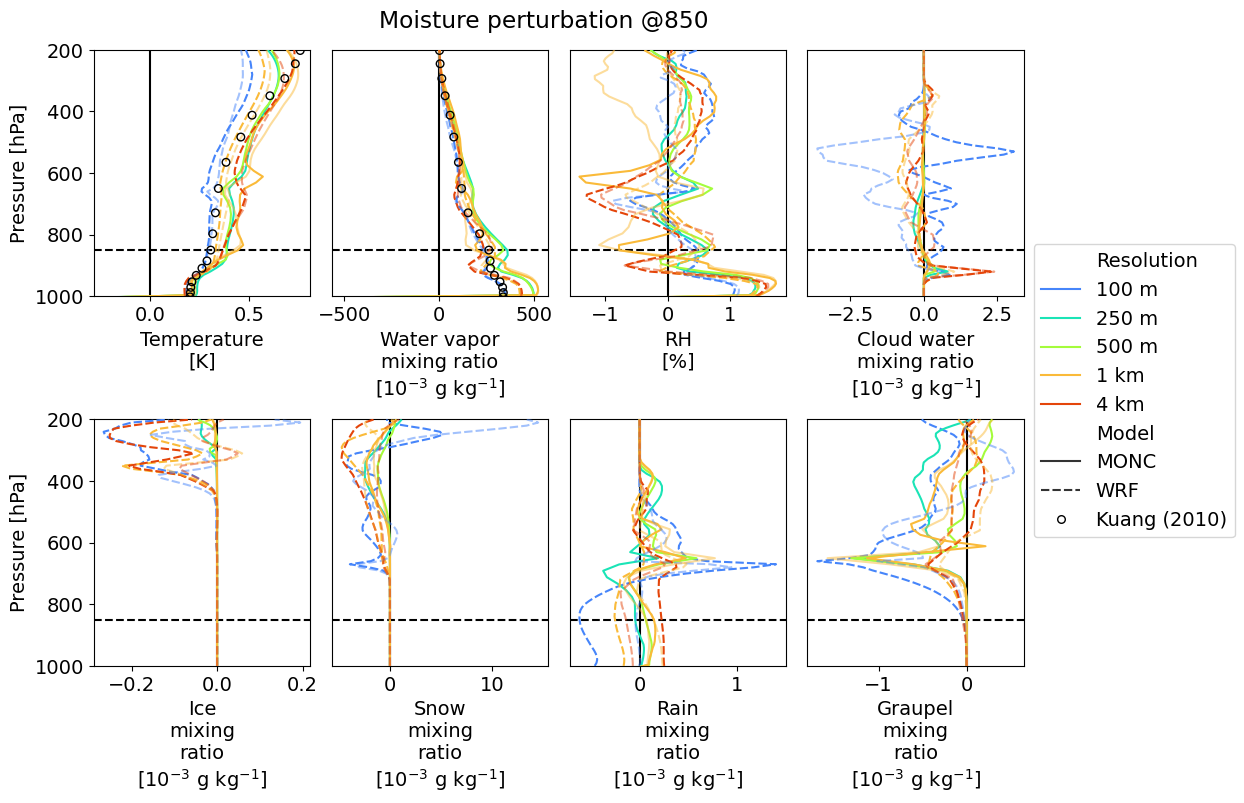

In [ ]:
wp.plot_responses(responses=all_responses, refs=ref_responses, show_negs=True)

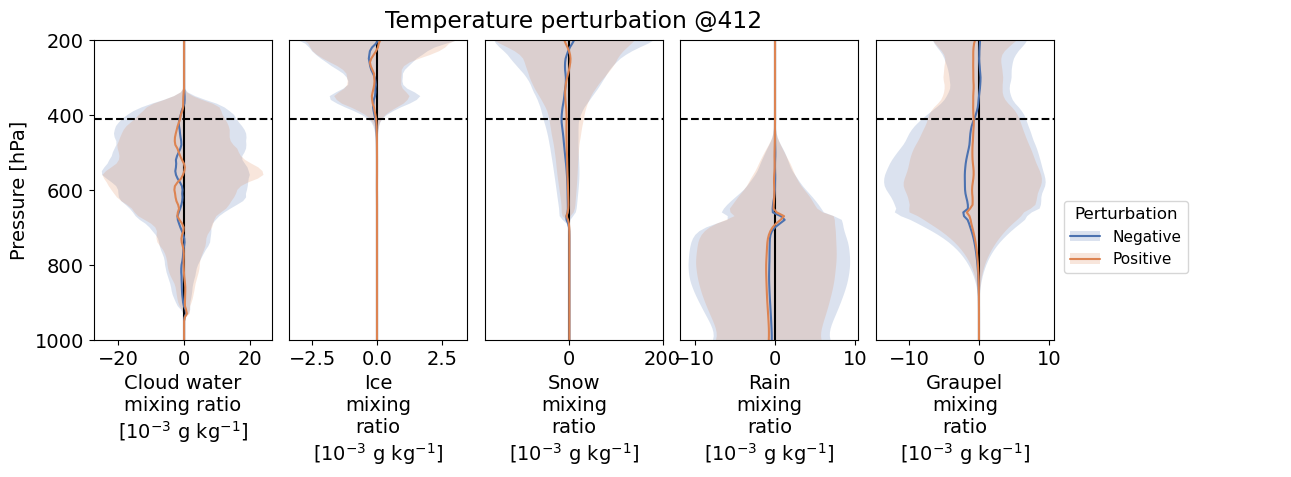

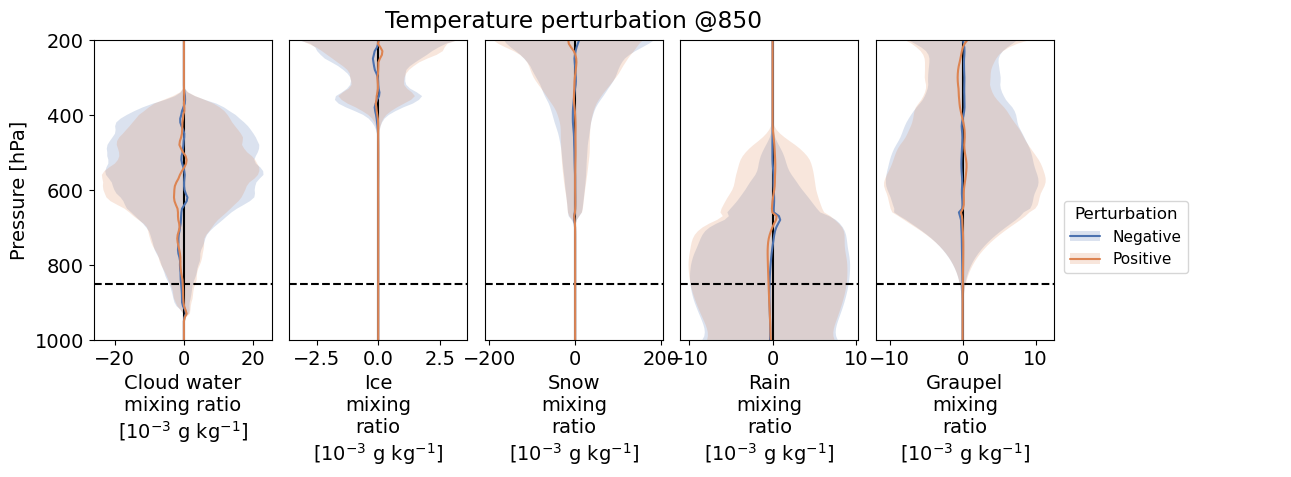

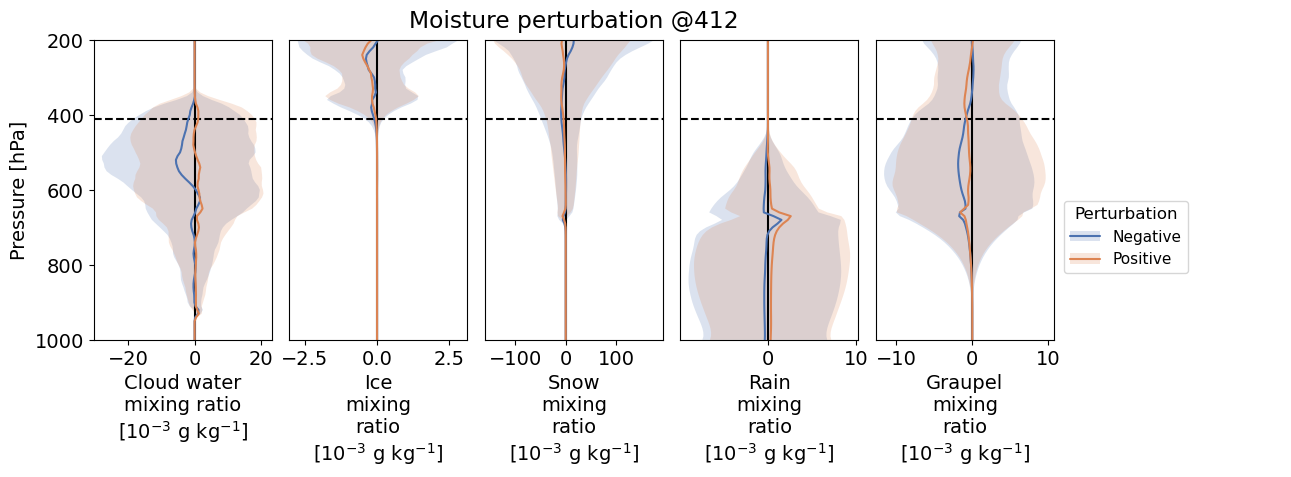

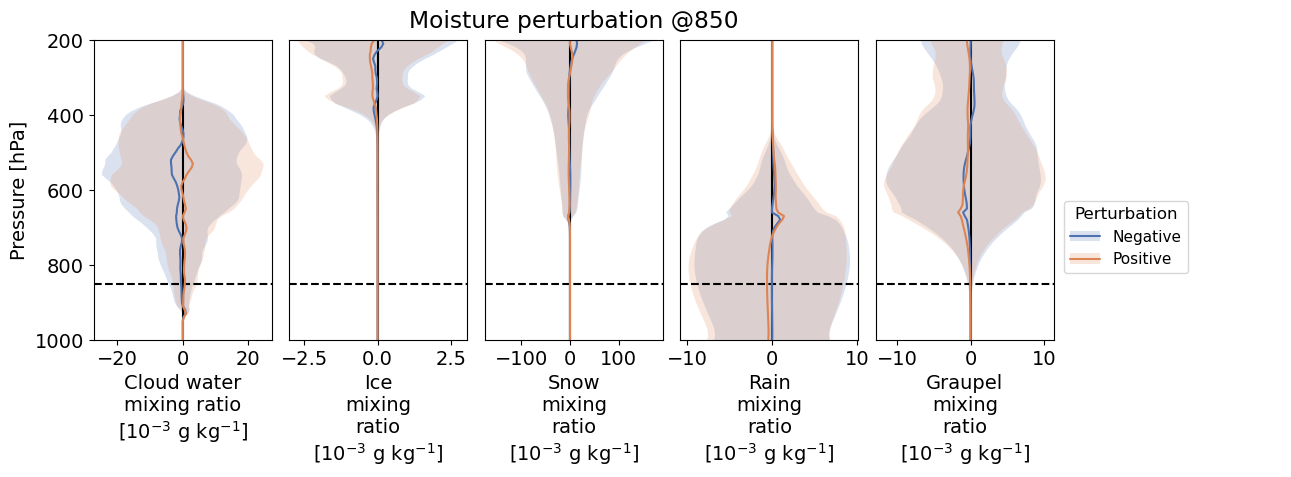

In [ ]:
wrf_stds = wrf_responses_std[wrf_responses_std.res == '100 m'].copy()
hydromet_vars=['q', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']
for v in hydromet_vars:
      wrf_stds[v] = wrf_stds[v] * 1000

wrf_resps = all_responses[
    np.logical_and(all_responses.Resolution == '100 m', all_responses.Model == 'WRF')
].dropna()

wp.plot_responses_with_std(resp=wrf_resps, std=wrf_stds)

### TODO:

- Check which turbulence closure scheme was used. Rerun 1km runs with different turbulence scheme to see differences?
- Try to figure out why the domain is drying out at about 850 hPa. 